# TP Synthèse harmonique

Dans ce TP, on va étudier le spectre d'une même note de musique jouée par deux instruments : un piano et une flûte. On étudiera la répartition des harmoniques, et on tentera de re-synthétiser cette note. 

In [1]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
%matplotlib inline

### Question 1
Importer les signaux audio. La fonction soundfile.read() permet d'importe les données audio (fichiers \*.aif ou \*.wav, ici). Si vous avez des problèmes avec cette fonction, vous pouvez importer directement le fichier \*.npy à l'aide de la fonction np.load. La fréquence d'échantillonnage est de 44.1 kHz. 

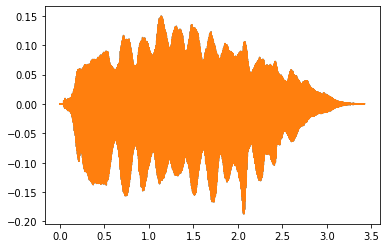

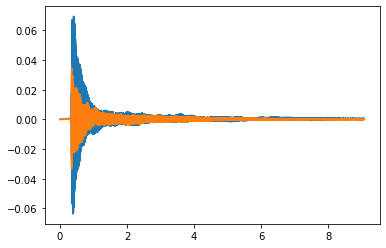

In [7]:
# flute = np.load("flute.npy")
# piano = np.load("piano.npy")
# fs = 44100

flute, fs = sf.read('flute.aif')
piano, fs = sf.read('piano.aiff')
dt = 1/fs

Nf = len(flute)
tf = np.linspace(0, (Nf - 1) * dt, Nf)
plt.plot(tf,flute)

plt.figure()
Np = len(piano)
tp = np.linspace(0, (Np - 1) * dt, Np)
plt.plot(tp,piano)

### Question 2 
Calculer et afficher le demi-spectre du signal (jusqu'à la fréquence de Nyquist). Quelles étaient vraisemblablement les fréquences présentes dans le signal continu ? Quelle hypothèse est nécessaire pour pouvoir faire cette interprétation ?

In [8]:
def myFFT(y, dt, plot = False):
    """
    Computes and optionnaly plots the samples of the half-spectrum of a signal
    sampled with a constant time step dt as a function of the continuous
    frequencies

    :param y: signal to be analyzed
    :param dt: sampling time step of the signal, in seconds
    :param plot: flag determining whether the function plots 
    the spectrum or not
    
    :type y: Numpy array
    :type dt: float
    :type plot: boolean

    :return: vector of continuous frequencies (in rad/s), Fast Fourier Transform of the signal y
    :rtype: Numpy arrays
    """
    
    N = len(y)
    freq = np.linspace(0,2*np.pi*(N-1)/N/dt,N)/2/np.pi
    Y = np.fft.fft(y-np.mean(y))
    if plot:
        plt.plot(freq[1:int(N/2)],np.abs(Y[1:int(N/2)])/np.amax(np.abs(Y[1:int(N/2)])))
        plt.show()
    return freq[1:int(N/2)], Y[1:int(N/2)]

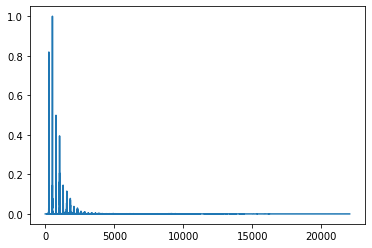

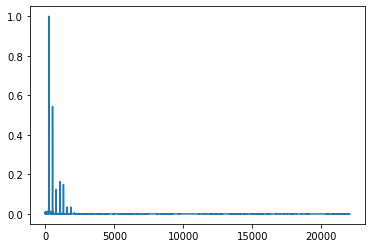

In [9]:
freqf, Yf = myFFT(flute[:,0],1./fs,True)
freqp, Yp = myFFT(piano[:,0],1./fs,True)

On trouve une fondamentale à 260 Hz et ses harmoniques. Il faut pour cela qu'aucun des pics en question ne soit en fait du repliement spectral, c'est-à-dire qu'il n'y ait aucune fréquence (significative) supérieure à 22.05 kHZ, ce qui est raisonnable pour les instruments considérés... Notons que la fréquence d'échantillonnage de 44.1 kHz est choisie pour être légèrement au-dessus de deux fois la fréquence maximale audible pour l'humain.

### Question 3
Qu'est-ce qui, a première vue, sépare le spectre de la note jouée par le piano de celle jouée par la flûte ? Quelles autres différences ne sont pas visibles sur le spectre ? 


La répartition des harmoniques est différente, les deuxièmes et troisièmes pics sont notamment beaucoup plus importants, relativement aux autres harmoniques, pour la flute. Il manque toutes les informations concernant les variations du spectre au cours du temps : l'"attaque", qui détermine à quelle vitesse on passe du silence à la note, les oscillations de l'amplitude de chaque harmonique, ainsi que la façon dont la note s'arrête... Certaines de ces informations se voient à l'oeil nu sur la représentation temporelle du spectre, d'autres nécessitent une analyse temps-fréquence.

### Question 4
On va réaliser un synthétiseur de notes de piano et de flûte, dans un premier temps assez simple. On va extraire du signal d'origine les amplitudes des pics principaux, et recréer des signaux à partir de sinusoïdes pures. Ecrire une fonction permettant d'extraire les N premiers maxima locaux d'un signal y(s). On pourra par exemple prendre d'abord le maximum absolu, puis exclure une bande de largeur $\Delta s$ autour de ce pic, pour ne pas prendre des pics trop proches dûs à l'étalement fréquentiel des notes considérées, puis itérer. 

In [13]:
def peakDetection(y,s,ds,N):
    """
    Computes the values of the local maxima of y(s) that are separated
    by at least ds / 2, as well as the values of s where these peaks are reached.
    
    :param y: input signal
    :param s: domain of definition of y
    :param ds: defines the minimum separation between peaks.
    :param N: number of peaks to be detected
    
    :type y: numpy array
    :type s: numpy array
    :type ds: float
    :type N: int
    
    
    :return sMax, yMax: location and value of the maxima
    :rtype: numpy arrays of size N
    """
    
    yNew = y
    sNew = s
    yMax = np.zeros(N)
    sMax = np.zeros(N)
    for n in range(N):
        yMax[n] = np.amax(np.abs(yNew))
        sMax[n] = sNew[np.argmax(np.abs(yNew))]
        yNew = yNew[np.abs(sNew - sMax[n]) > ds/2]
        sNew = sNew[np.abs(sNew - sMax[n]) > ds/2]
    return sMax, yMax

In [14]:
Npeaks = 10
df = 300
freqPianoMax, pMax = peakDetection(Yp,freqp,df,Npeaks)
freqFluteMax, flMax = peakDetection(Yf,freqf,df,Npeaks)

### Question 5
Créer des signaux synthétiques de la note jouée par le piano et la flûte, uniquement à l'aide de sinusoïdes. On pourra se servir de la fonction sf.write() pour créer des signaux audio. La différence entre les signaux synthétiques et les signaux d'origine se trouve entièrement dans l'évolution du contenu fréquentiel au cours du temps. 

In [ ]:
T = 2
t = np.arange(0,T,1/fs)
dt = 1/fs
pianoSynth = np.zeros(len(t))
fluteSynth = np.zeros(len(t))

"""Flute"""
N = len(flute[:,0]) # Longueur du signal de la flute
omega_k = 2*np.pi*freqFluteMax.reshape(1, Npeaks) # pulsations \omega_k où se réalisent les Npeaks
time_range = dt*np.arange(N).reshape(N, 1) # les n*Delta_t, avec Delta_t = 1/fs
n_omega_k_t = time_range.dot(omega_k) # matrice de taille N x Npeaks, contenant les n*omega_k*Delta_t
sin_n_omega_k_t = np.sin(n_omega_k_t)# matrice de taille N x Npeaks, contenant les sin (n*omega_k*Delta_t )
A_fl = np.ones((N, 1)).dot(flMax.reshape(1, Npeaks)) # amplitudes des pics
fluteSynth = np.sum(A_fl*sin_n_omega_k_t, axis = 1)
sf.write('pianoSynth.wav',pianoSynth,fs)
sf.write('fluteSynth.wav',fluteSynth,fs)

"""Piano"""
N = len(piano[:,0]) # Longueur du signal du piano
omega_k = 2*np.pi*freqPianoMax.reshape(1, Npeaks) # pulsations \omega_k où se réalisent les Npeaks
time_range = dt*np.arange(N).reshape(N, 1) # les n*Delta_t, avec Delta_t = 1/fs
n_omega_k_t = time_range.dot(omega_k) # matrice de taille N x Npeaks, contenant les n*omega_k*Delta_t
sin_n_omega_k_t = np.sin(n_omega_k_t)# matrice de taille N x Npeaks, contenant les sin (n*omega_k*Delta_t )
A_p = np.ones((N, 1)).dot(pMax.reshape(1, Npeaks)) # amplitudes des pics
pianoSynth = np.sum(A_p*sin_n_omega_k_t, axis = 1)

In [ ]:
myFFT(piano[:,0],1/fs,True)
myFFT(pianoSynth,1/fs,True)

### Complément: approche alternative pour la synthèse du signal

Une approche alternative pour re-synthétiser le signal peut être de ne garder qu'une petite proportion des coefficients de Fourier du signal, plus précisément ceux de plus grande amplitude, et de fixer les autres à 0. Pour ce faire, on procède de la manière qui suit:
- on calcule la transformée de Fourier du signal
- on détermine les N coefficients de plus grand module
- on fixe les autres coefficients à zéro
- on reconstruit le signal par transformée de Fourier inverse


In [ ]:
# Calcul des coefficients de Fourier du signal
piano_hat = np.fft.fft(piano[:,0])

# Tri des coefficients en fonction de leur module
# On seuille ensuite les coefficients de Fourier pour ne garder que les N coefficients les plus grands
coeff_sorted = np.sort(np.abs(piano_hat))
N = 1000
threshold = coeff_sorted[-N]
mask = np.ones_like(piano_hat)
mask[np.abs(piano_hat) < threshold] = 0.
piano_hat_thresholded = piano_hat*mask
print("Pourcentage de coefficients conservés : " + str(100*N/piano_hat.size) + "%")

# Transformée de Fourier inverse
piano_synthesis = np.fft.ifft(piano_hat_thresholded).astype('float64')

# trace le signal reconstruit
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
ax[0].plot(piano[:,0])
ax[1].plot(piano_synthesis)
plt.show()

# Enregistrement du son correspondant
sf.write('pianoSynth2.wav',piano_synthesis,fs)
